In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys
import astropy.units as units
import pandas as pd
import lightkurve as lk
import importlib


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]

In [3]:
lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,17):
    lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))


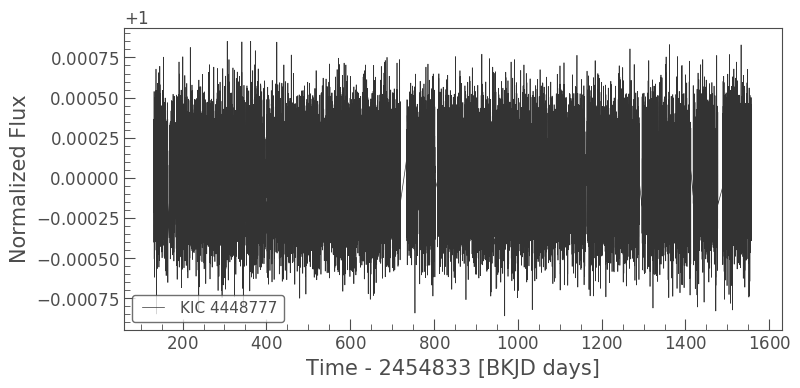

In [4]:
lc = lc.remove_outliers(4)
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0).flatten()

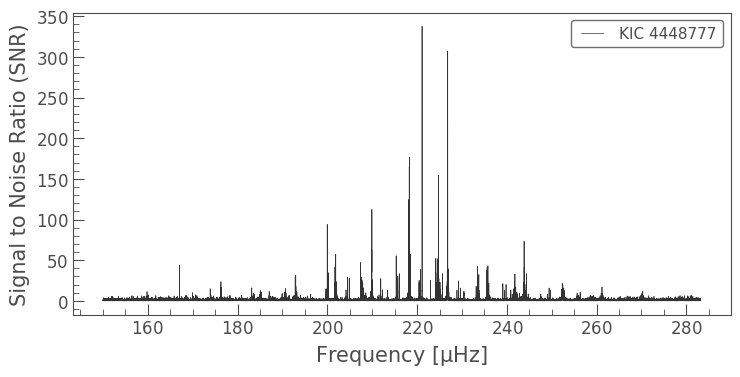

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

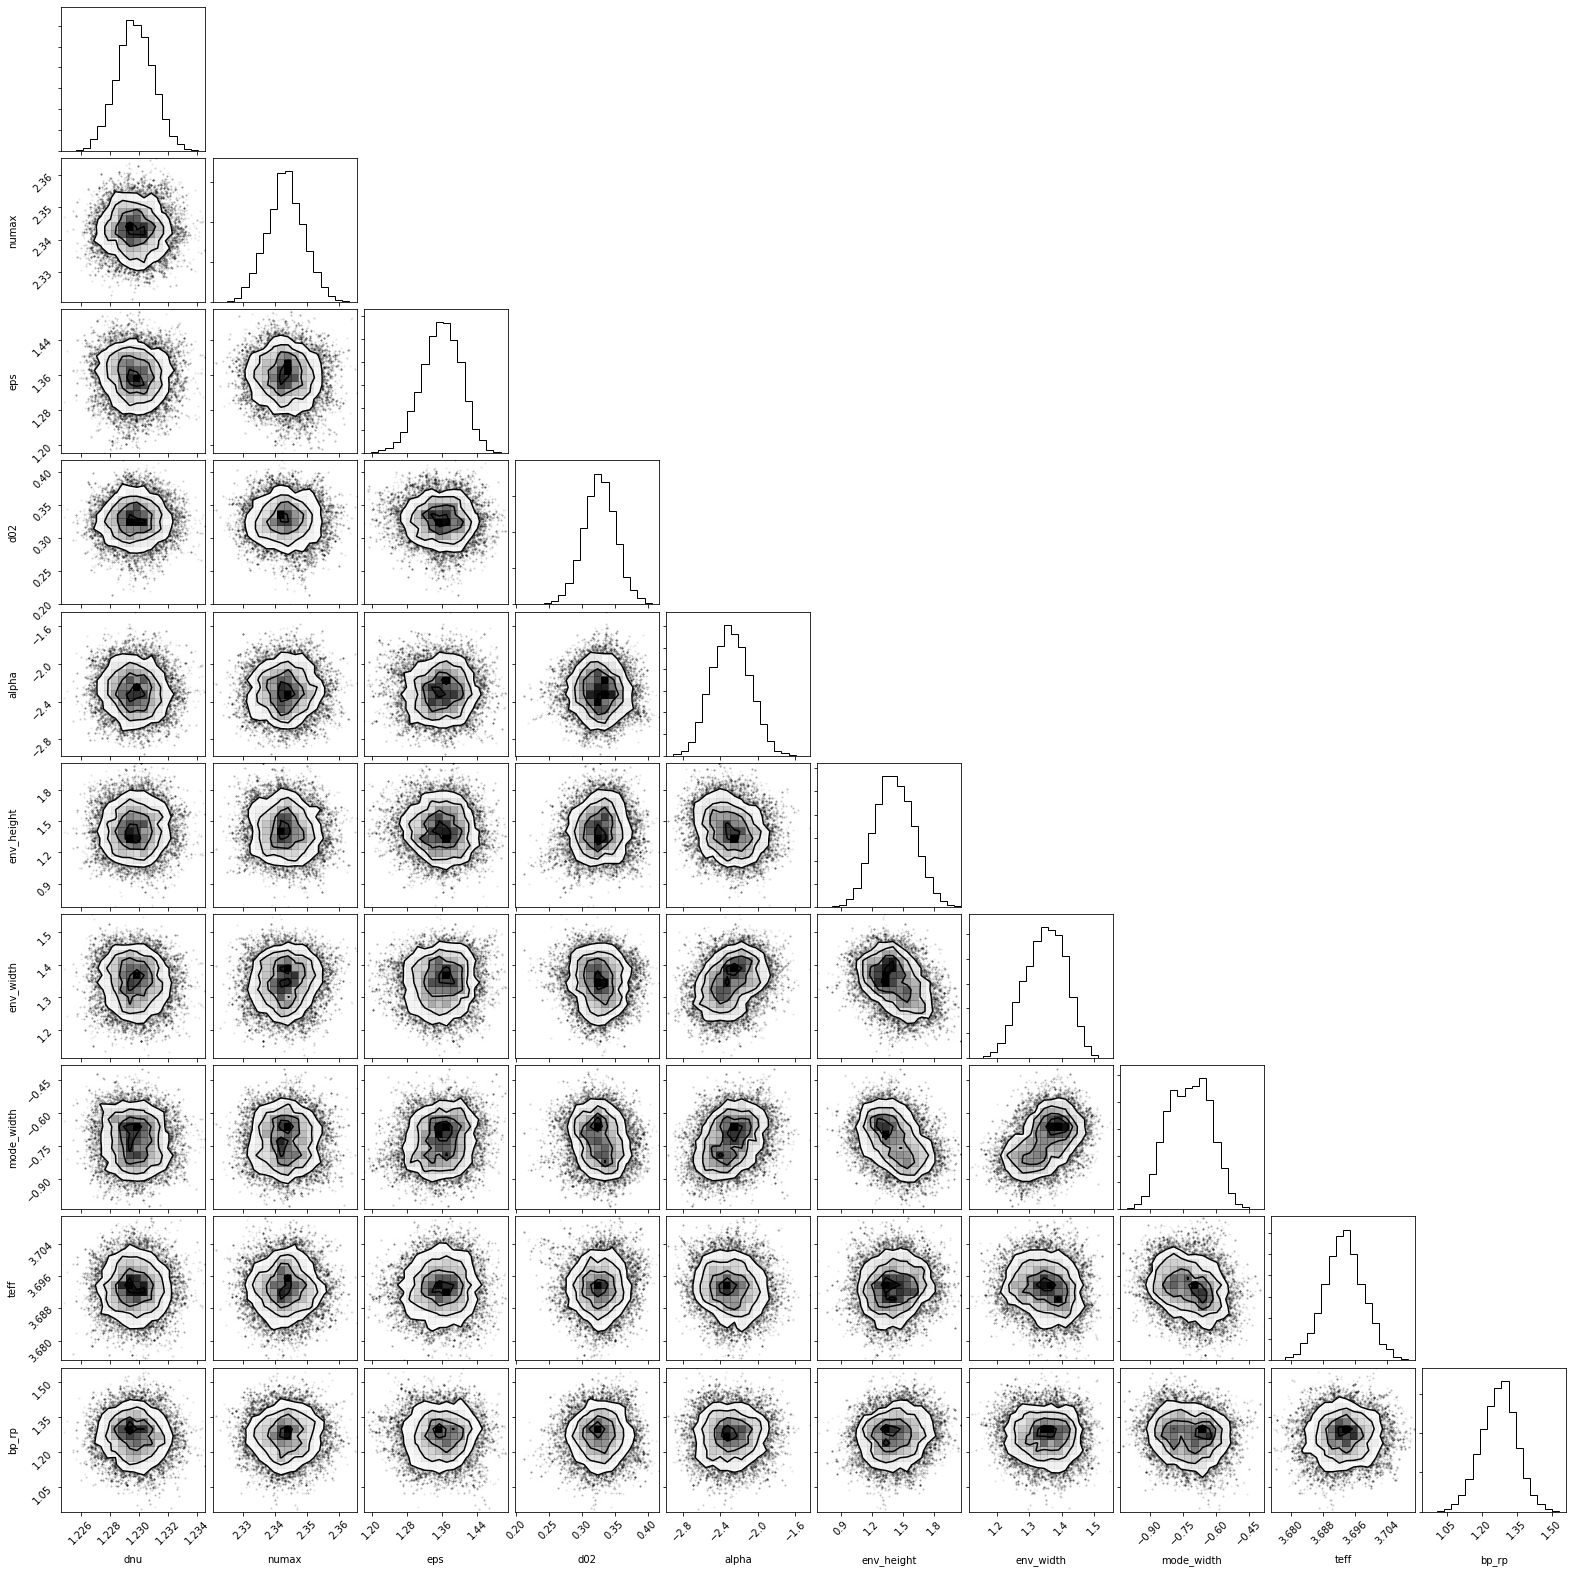

In [8]:
import corner
corner.corner(ep.samples, labels=ep.cols);

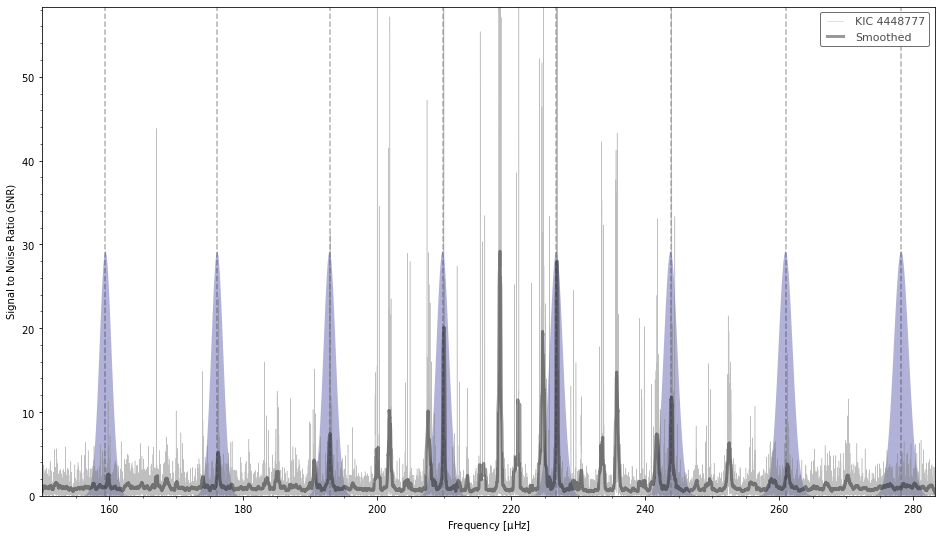

In [9]:
ep.plot(pg)

In [10]:
importlib.reload(pb.asy_peakbag)
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=4, norders=5,
                                    store_chains=True)

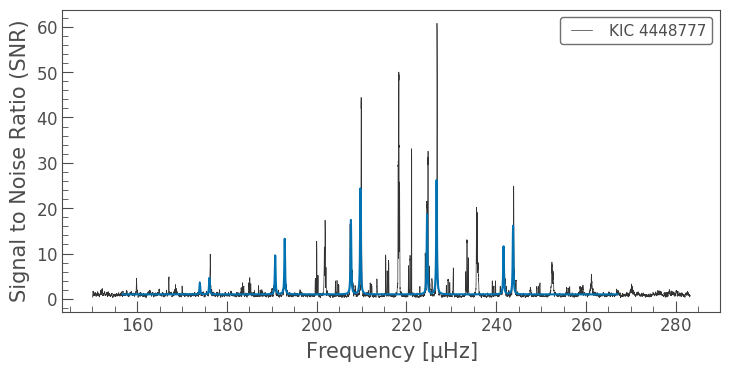

In [11]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.start))

In [12]:
asy_result = asy.run(burnin=1000, niter=1000)

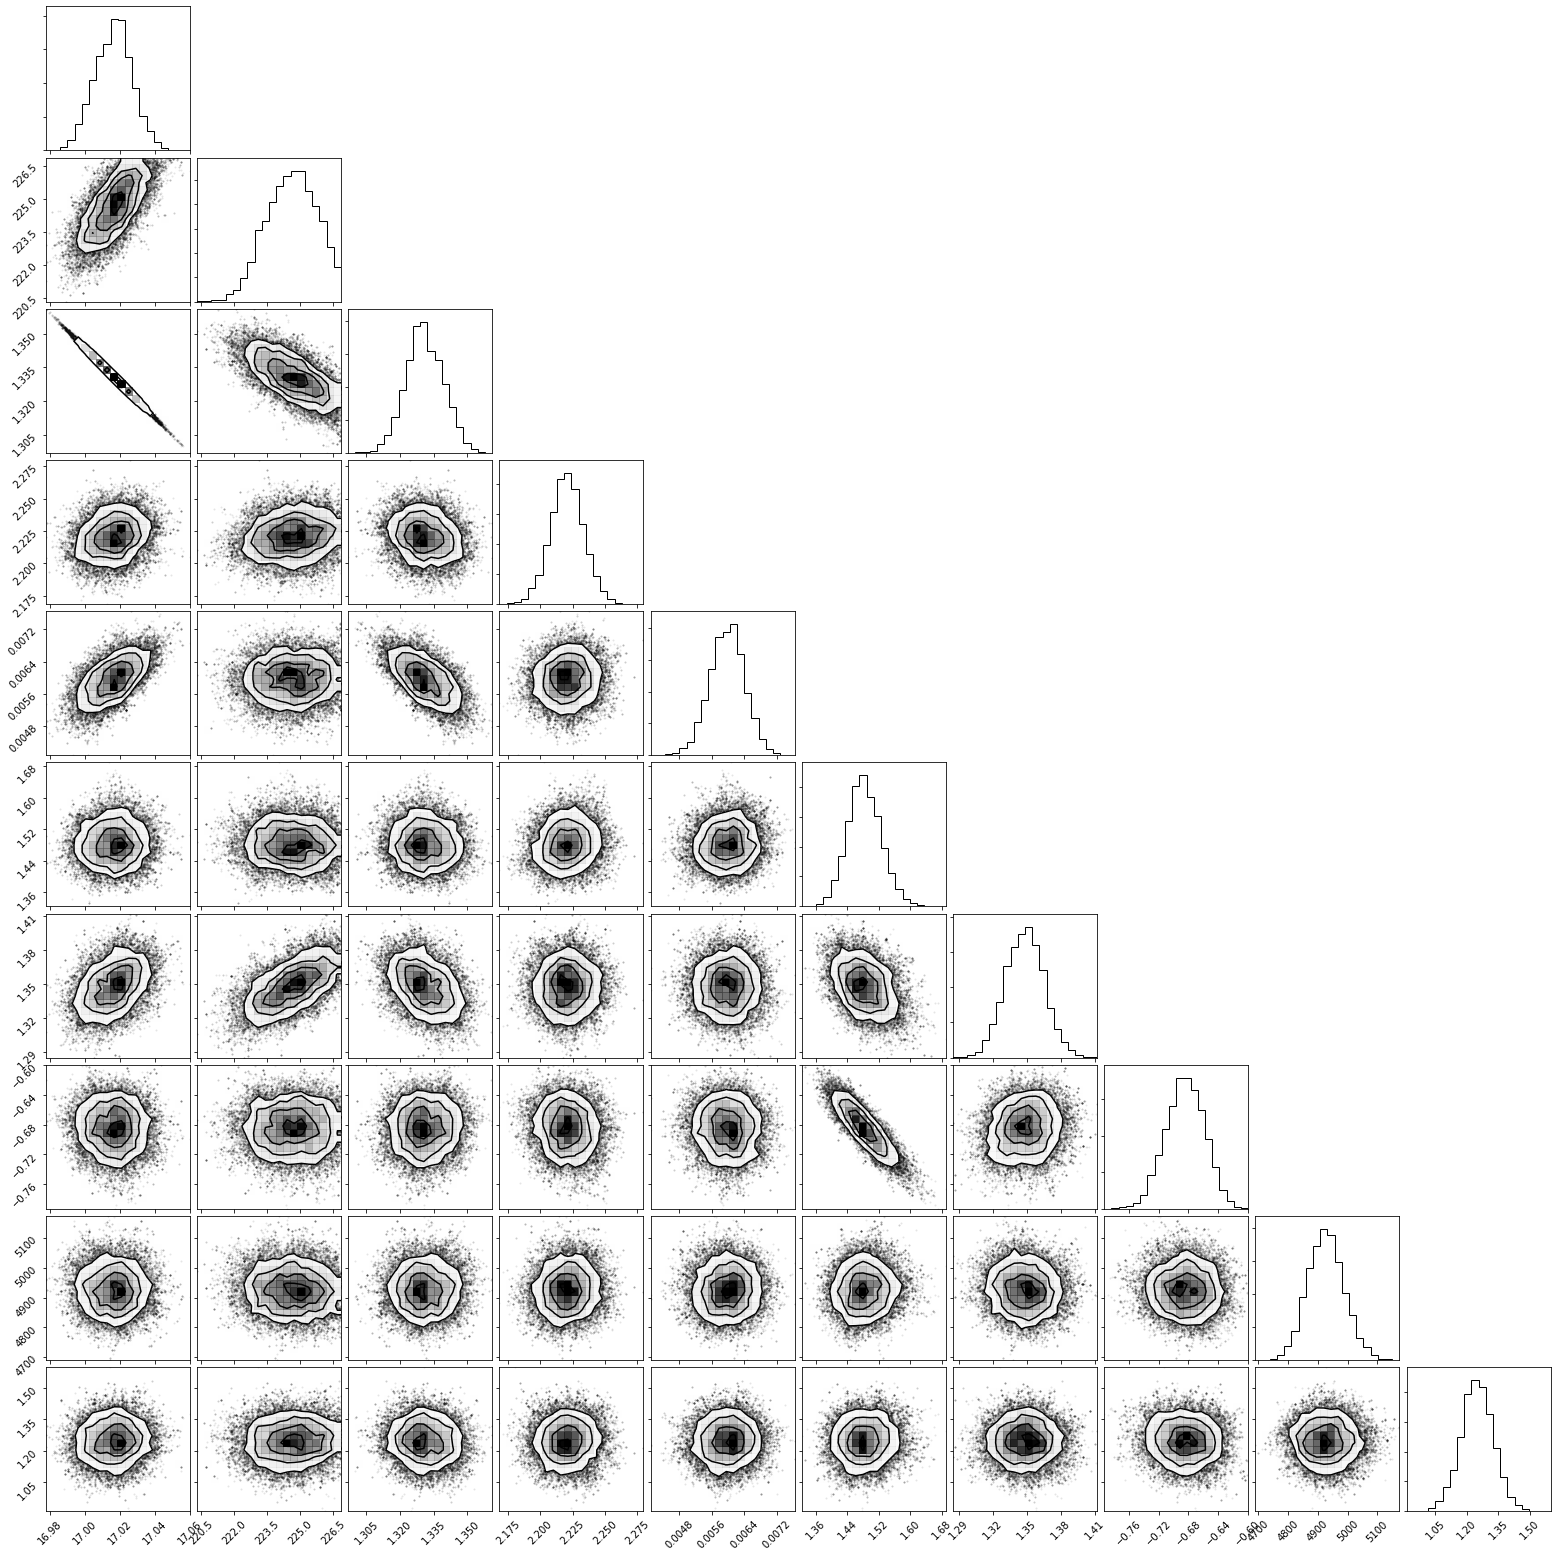

In [13]:
corner.corner(asy.flatchain);

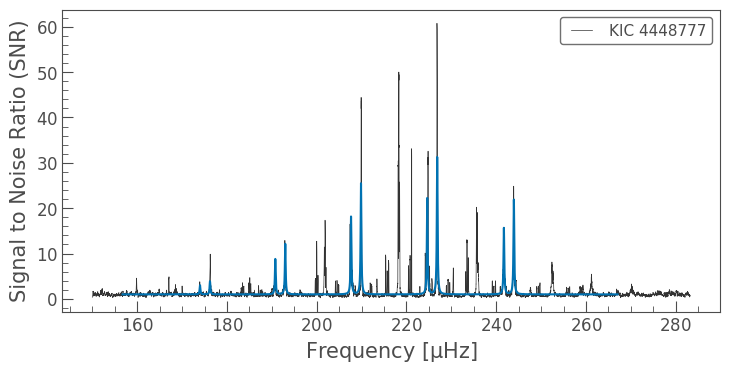

In [14]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.flatchain.mean(axis=0)))

In [15]:
asy_result['summary']

,dnu,numax,eps,d02,alpha,env_height,env_width,mode_width,teff,bp_rp
16th,17.005222,223.419972,1.322696,2.208054,0.005545,1.441354,1.331213,-0.711349,4865.955507,1.173115
2nd,16.995204,222.378469,1.314449,2.194273,0.005102,1.402303,1.314869,-0.736746,4810.239599,1.091039
50th,17.016767,224.644463,1.330449,2.220491,0.005985,1.480710,1.348307,-0.684526,4925.930103,1.248006
84th,17.026783,225.794308,1.339443,2.233517,0.006396,1.525932,1.364896,-0.658102,4987.855117,1.325554
97th,17.037334,226.588236,1.347102,2.246948,0.006813,1.572635,1.382624,-0.634506,5055.506497,1.402171
MAD,0.010796,1.200510,0.008451,0.012524,0.000421,0.042361,0.017087,0.026612,61.467263,0.075736
mean,17.016255,224.601535,1.330887,2.220702,0.005974,1.483381,1.348094,-0.684641,4927.241970,1.248330
mle,17.019027,224.976993,1.328731,2.221157,0.005969,1.476170,1.346360,-0.675448,4929.650294,1.254099
skew,-0.034064,-0.218459,0.030111,0.024592,-0.087800,0.216933,0.021909,-0.111753,0.155397,-0.007890
std,0.010695,1.110921,0.008304,0.012904,0.000430,0.042801,0.016859,0.026058,61.036606,0.077285


In [16]:
import importlib
import pbjam

In [17]:
#importlib.reload(pbjam)
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

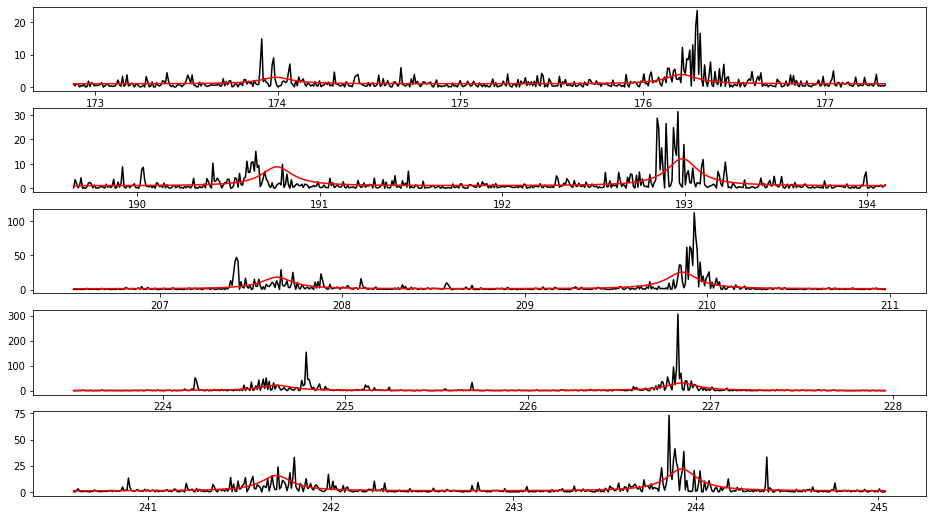

In [18]:
pbag.plot_start_model()

In [19]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:35<00:00, 225.60draws/s]


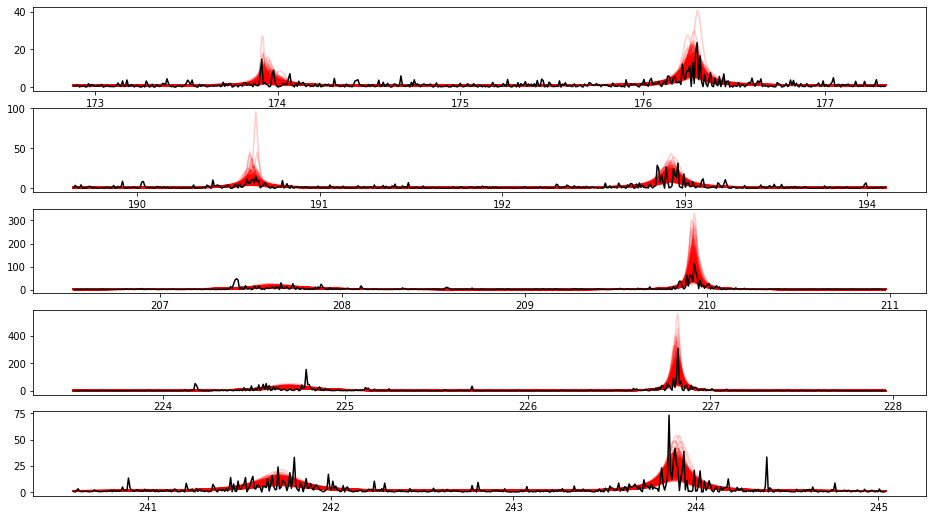

In [20]:
pbag.plot_fit(thin=1)